# RRAM Characterization Analysis Notebook

This notebook contains Python analyses of data collected on the 256x256 (64K) TCAM array developed at Stanford. The TCAM has 4 WLs that are addressed by a single WL addr, and 2 BLs that are addressed by a single SL addr.

## Notebook setup

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import pandas as pd
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import Formatter, FixedLocator
from matplotlib.patches import Rectangle

In [2]:
# Set up PPF scale for CDF plots
class PPFScale(mscale.ScaleBase):
    name = "ppf"

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self, axis)

    def get_transform(self):
        return self.PPFTransform()

    def set_default_locators_and_formatters(self, axis):
        class VarFormatter(Formatter):
            def __call__(self, x, pos=None):
                return f"{x}"[1:]

        axis.set_major_locator(FixedLocator(np.array([0,.0001,.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99,.999,.9999,1])))
        axis.set_major_formatter(VarFormatter())


    def limit_range_for_scale(self, vmin, vmax, minpos):
        return max(vmin, 1e-6), min(vmax, 1-1e-6)

    class PPFTransform(mtransforms.Transform):
        input_dims = output_dims = 1

        def ___init__(self, thresh):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            return stats.norm.ppf(a)

        def inverted(self):
            return PPFScale.IPPFTransform()

    class IPPFTransform(mtransforms.Transform):
        input_dims = output_dims = 1

        def transform_non_affine(self, a):
            return stats.norm.cdf(a)

        def inverted(self):
            return PPFScale.PPFTransform()

# Register PPF scale
mscale.register_scale(PPFScale)

## Calibration

### Read voltage sweep

Here, we sweep the READ voltage across different programmed conductances and measure average current to see how "linear" the RRAM is. At all conductances tested, the I-V curves appear to be very linear. This ohmic behavior may simplify sense amplifier design and improve accuracy.

We will operate at 0.2V READ voltage during the remainder of these experiments, but this data confirms that the resistances/conductances measured will look similar at other READ voltages.

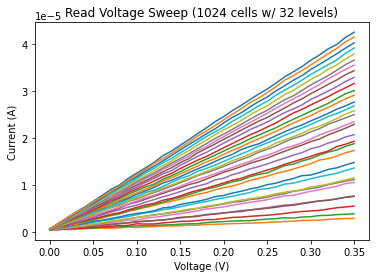

In [3]:
# Load data and get bin values
names = ["addr", "v", "i"]
data = pd.read_csv("../data/read_voltage_sweep.tsv", sep="\t", names=names)
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32

# Plot bin values
plt.title("Read Voltage Sweep (1024 cells w/ 32 levels)")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
for targbin in range(32):
    gdata = data[data["targbin"] == targbin].groupby(["v"])
    plt.plot(gdata["v"].mean(), gdata["i"].mean())
plt.show()

## FORMing

### Load log file

The log file contains all the data from the dynamic FORM process. We need to parse it and look at some statistical properties of the FORMing process.

In this dataset, FORMing is done by dynamically incrementing VWL by 50mV starting from 1.3V until the cell resistance falls below 10kOhm. The VBL is fixed at 3.3V and the pulse width is 1ms.

In [4]:
# Load log file
names = ["chip", "time", "addr", "operation", "data0", "data1", "data2", "data3"]
data = pd.read_csv("../data/form2_log.csv", names=names)

# Get data from last FORM pulse and final resistance measurement only
read_data = data[data["operation"] == "READ"].groupby("addr").nth(-1)
form_data = data[data["operation"] == "SET"].groupby("addr").nth(-1)

# For SET operations: (data0, data1, data2, data3) = (VWL, VBL, VSL, PW)
# For READ operations: (data0, data1, data2, data3) = (res, g, meas_i, meas_v)
# res = resistance, g = conductance

data

chip          time   addr operation         data0         data1  \
0        C6  1.619165e+09      0       SET  1.300000e+00  3.300000e+00   
1        C6  1.619165e+09      0      READ  9.533862e+03  1.048893e-04   
2        C6  1.619165e+09      1       SET  1.300000e+00  3.300000e+00   
3        C6  1.619165e+09      1      READ  2.021986e+06  4.945633e-07   
4        C6  1.619165e+09      1       SET  1.350000e+00  3.300000e+00   
...     ...           ...    ...       ...           ...           ...   
785673   C6  1.619169e+09  65535      READ  1.005330e+04  9.946987e-05   
785674   C6  1.619169e+09  65535       SET  1.500000e+00  3.300000e+00   
785675   C6  1.619169e+09  65535      READ  1.023959e+04  9.766017e-05   
785676   C6  1.619169e+09  65535       SET  1.550000e+00  3.300000e+00   
785677   C6  1.619169e+09  65535      READ  9.480846e+03  1.054758e-04   

               data2     data3  
0       0.000000e+00  0.001000  
1       1.981402e-05  0.011096  
2       0.000000e+00  0.001000  
3       9.888527e-08  0.000055  
4       0.000000e+00  0.001000  
...              ...       ...  
785673  1.884429e-05  0.010553  
785674  0.000000e+00  0.001000  
785675  1.851922e-05  0.010371  
785676  0.000000e+00  0.001000  
785677  1.991864e-05  0.011154  

[785678 rows x 8 columns]

### FORMing VWL Distribution

As shown by the distribution, most cells FORM with a single pulse as indicated by the large bar at 1.3V (first pulse). The rest of the cells appear to FORM in a manner that looks like the right half of a Gaussian distribution.

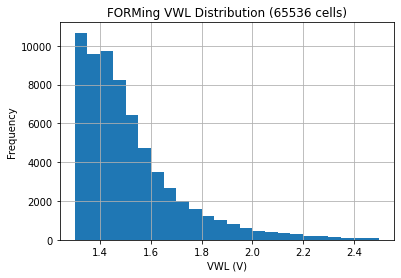

In [5]:
# VWL Distribution
form_data["data0"].hist(bins=np.arange(1.3, 2.51, 0.05001))
plt.title("FORMing VWL Distribution (65536 cells)")
plt.xlabel("VWL (V)")
plt.ylabel("Frequency")
plt.show()

### FORMing Conductance Distribution

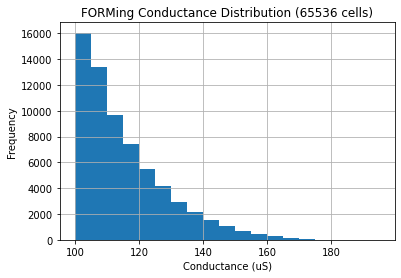

In [6]:
# Conductance Distribution
(read_data["data1"] * 1e6).hist(bins=np.arange(100, 200, 5))
plt.title("FORMing Conductance Distribution (65536 cells)")
plt.xlabel("Conductance (uS)")
plt.ylabel("Frequency")
plt.show()

### FORMing VWL Spatial Distribution

There seems to be a pattern in the FORMing voltages, repeating every 8 columns. This is probably a layout-dependent effect, as there is segmentation in the wordlines. The FORMing voltage appears to be lower at the edges.


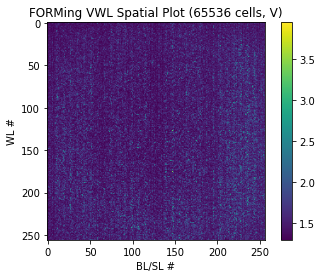

In [7]:
# FORMing VWL
mat = plt.imshow(form_data["data0"].values.reshape(256,256), interpolation=None)
plt.colorbar(mat)
plt.title("FORMing VWL Spatial Plot (65536 cells, V)")
plt.xlabel("BL/SL #")
plt.ylabel("WL #")
plt.show()

### FORMing Conductance Distribution

From the FORMing conductance distribution, we can infer that it is more difficult to bring the darker stripes of cells below 10kOhm, so the VWL is higher for those cells accordingly.

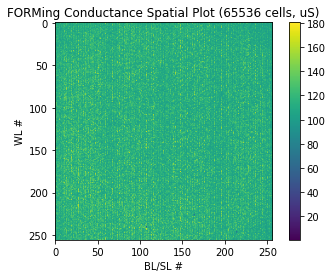

In [8]:
# FORMing Conductance
mat = plt.imshow(read_data["data1"].values.reshape(256,256) * 1e6, interpolation=None)
plt.colorbar(mat)
plt.title("FORMing Conductance Spatial Plot (65536 cells, uS)")
plt.xlabel("BL/SL #")
plt.ylabel("WL #")
plt.show()

## Multi-Bit Capability Evaluation

The first multi-bit test examines the post-programmed readout of 32 levels induced across the first 1024 cells of the array (32 cells/level * 32 levels). The programming method is DD-ISPP (dual-direction incremental step pulse programming), where the word line voltage is incremented until the cells fall into the target range. The main finding was that only the first bit line of the TCAM supports good multi-bit programming while the second bit line has huge relaxation problems. This may have something to do with the TCAM peripherals causing write disturbance. The data that led to this conclusion is presented below. All measurements are taken 15-30 minutes after programming. More information on the time-dependence of the distributions is given in the [Retention](#retention) section.

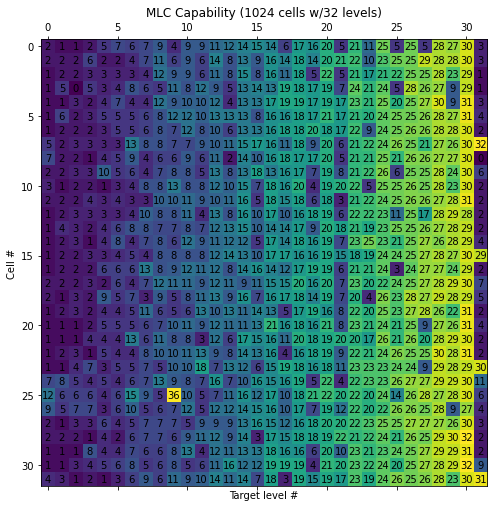

In [9]:
# Load data
names = ["addr", "r"]
data = pd.read_csv("../data/read_mlc_bad.tsv", sep="\t", names=names)
data["g"] = 1/data["r"]

# Show multi-bit result
plt.rcParams["figure.figsize"] = (8,8)
data["bin"] = np.floor(data["g"] / 4e-6)
data["targbin"] = (data["addr"] - data["addr"][0]) % 32
matdata = data["bin"].values.reshape(32,32)
plt.matshow(matdata, vmin=0, vmax=32)
plt.title("MLC Capability (1024 cells w/32 levels)")
plt.xlabel("Target level #")
plt.ylabel("Cell #")
for i in range(len(matdata)):
    for j in range(len(matdata[0])):
        c = int(matdata[j,i])
        plt.text(i, j, str(c), va="center", ha="center")
plt.show()

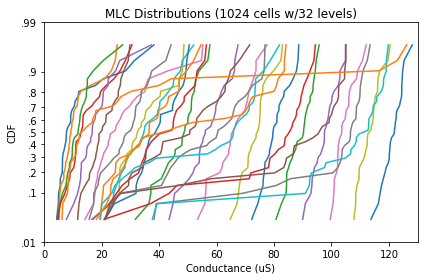

In [10]:
# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (1024 cells w/32 levels)")
for i in range(32):
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 130)
plt.ylim(0.01, 0.99)
plt.tight_layout()
plt.show()

Note that every second cell (corresponding to the second bitline) above looks like it has deviated significantly from its programmed value. Next, we examine only cells on the first bitline to remove these outliers.

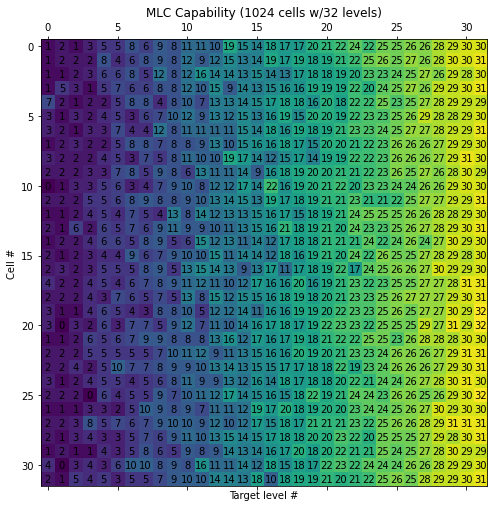

In [11]:
# Load data
names = ["addr", "r"]
data = pd.read_csv("../data/read_mlc_good.tsv", sep="\t", names=names)
data["g"] = 1/data["r"]

# Show multi-bit result
plt.rcParams["figure.figsize"] = (8,8)
data["bin"] = np.floor(data["g"] / 4e-6)
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32
matdata = data["bin"].values.reshape(32,32)
plt.matshow(matdata, vmin=0, vmax=32)
plt.title("MLC Capability (1024 cells w/32 levels)")
plt.xlabel("Target level #")
plt.ylabel("Cell #")
for i in range(len(matdata)):
    for j in range(len(matdata[0])):
        c = int(matdata[j,i])
        plt.text(i, j, str(c), va="center", ha="center")
plt.show()

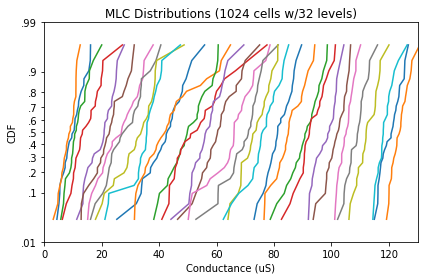

In [12]:
# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (1024 cells w/32 levels)")
for i in range(32):
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 130)
plt.ylim(0.01, 0.99)
plt.tight_layout()
plt.show()

Now, we can try to pick out non-overlapping levels and examine them more carefully. We can get 5 non-overlapping levels here.

In [13]:
# Define the non-overlapping levels
levels = [31, 26, 21, 12, 1]

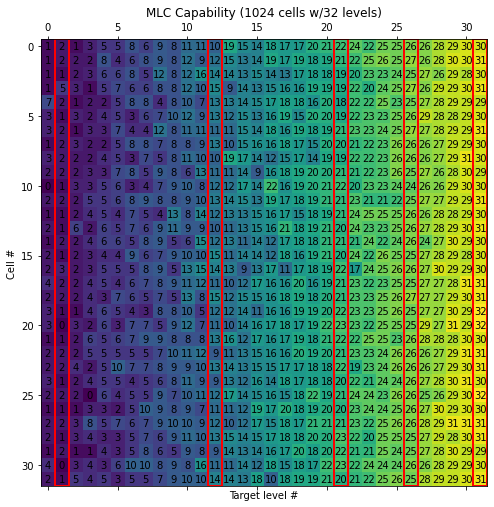

In [14]:
# Show multi-bit result
plt.rcParams["figure.figsize"] = (8,8)
data["bin"] = np.floor(data["g"] / 4e-6)
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32
matdata = data["bin"].values.reshape(32,32)
plt.matshow(matdata, vmin=0, vmax=32)
plt.title("MLC Capability (32 cells/level")
plt.xlabel("Target level #")
plt.ylabel("Cell #")
for i in range(len(matdata)):
    for j in range(len(matdata[0])):
        c = int(matdata[j,i])
        plt.text(i, j, str(c), va="center", ha="center")
for level in levels:
    rect = Rectangle((level - 0.5, -0.5), 1, 32, linewidth=2, edgecolor="r", facecolor="none")
    plt.gca().add_patch(rect)
plt.show()

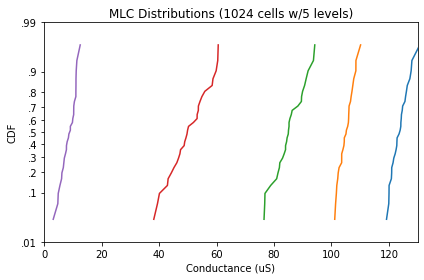

In [15]:
# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (5 levels w/32 cells each)")
for i in levels:
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 130)
plt.ylim(0.01, 0.99)
plt.tight_layout()
plt.show()

Let's examine the distributions with more data now (16378 cells):

In [16]:
# Load data
names = ["addr", "time", "r", "g"]
data = pd.read_csv("../data/retention-many.tsv.gz", names=names, sep="\t")
data["time"] = data["time"] - data.groupby("addr")["time"].transform("first")
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32

data

addr          time              r         g  targbin
0            0      0.000000    8984.367718  0.000111      0.0
1            2      0.000000  149959.884148  0.000007      1.0
2            4      0.000000  183820.407835  0.000005      2.0
3            6      0.000000  190713.034545  0.000005      3.0
4            8      0.000000   59833.865834  0.000017      4.0
...        ...           ...            ...       ...      ...
3562179  13702  15578.781133   59588.511960  0.000017      3.0
3562180  13704  15578.780234   78803.267971  0.000013      4.0
3562181  13706  15578.781469   39429.608924  0.000025      5.0
3562182  13708  15578.782169   33700.227612  0.000030      6.0
3562183  13710  15578.782941   46932.410196  0.000021      7.0

[3562184 rows x 5 columns]

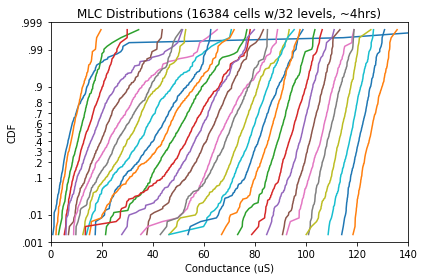

In [17]:
# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (16384 cells w/32 levels, ~4hrs)")
tdata = data.groupby("addr").nth(-1)
for i in range(32):
    rdata = tdata[tdata["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 140)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

If we filter down to 5 levels:

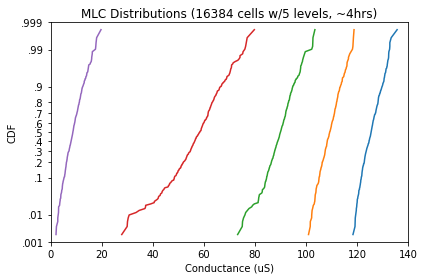

In [18]:
# Define the non-overlapping levels
levels = [31, 27, 22, 14, 1]

# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (16384 cells w/5 levels, ~4hrs)")
tdata = data.groupby("addr").nth(-1)
for i in levels:
    rdata = tdata[tdata["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 140)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

If we filter down to 4 levels:

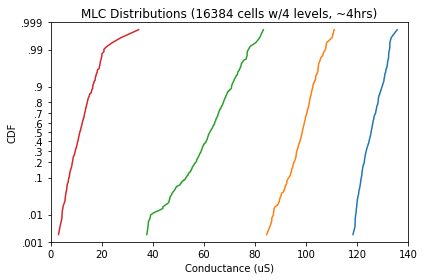

In [19]:
# Define the non-overlapping levels
levels = [31, 24, 15, 2]

# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (16384 cells w/4 levels, ~4hrs)")
tdata = data.groupby("addr").nth(-1)
for i in levels:
    rdata = tdata[tdata["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 140)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

<a id="retention"></a>
## Retention and Read Noise
In this section, we evaluate how well the cells can maintain their conductance values after programming. We first program 1024 cells (using the first bitline). After each cell is programmed, we immediately measure the short-term relaxation by performing 1000 READs. After all cells are programmed, we measure the long-term relaxation by continuously reading all cells.

### Room-Temperature Retention/Read Noise

In [20]:
# Open read file
names = ["addr", "time", "r", "g"]
data = pd.read_csv("../data/retention.tsv.gz", names=names, sep="\t")
data["time"] = data["time"] - data.groupby("addr")["time"].transform("first")
data["dg"] = data["g"] - data.groupby("addr")["g"].transform("first")
data["absdg"] = np.abs(data["dg"])
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32
data

addr          time              r         g            dg  \
0           0      0.000000  104506.555016  0.000010  0.000000e+00   
1           0      0.004000   89717.187950  0.000011  1.577358e-06   
2           0      0.007997  105905.073584  0.000009 -1.263595e-07   
3           0      0.011993  113477.254385  0.000009 -7.564391e-07   
4           0      0.015990  126629.661971  0.000008 -1.671734e-06   
...       ...           ...            ...       ...           ...   
5849319   462  24257.955601   22572.876611  0.000044  1.314708e-05   
5849320   464  24254.084537   20166.780035  0.000050  1.620586e-05   
5849321   466  24250.099089   35920.176541  0.000028 -1.111323e-05   
5849322   468  24246.142325   22084.324331  0.000045 -4.050034e-07   
5849323   470  24242.198276   22992.548301  0.000043 -1.255452e-06   

                absdg  targbin  
0        0.000000e+00      0.0  
1        1.577358e-06      0.0  
2        1.263595e-07      0.0  
3        7.564391e-07      0.0  
4        1.671734e-06      0.0  
...               ...      ...  
5849319  1.314708e-05      7.0  
5849320  1.620586e-05      8.0  
5849321  1.111323e-05      9.0  
5849322  4.050034e-07     10.0  
5849323  1.255452e-06     11.0  

[5849324 rows x 7 columns]

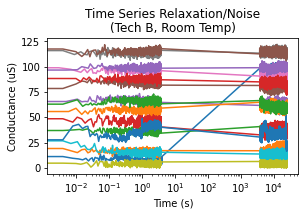

In [21]:
# Plot measured conductance vs. time
fig = plt.figure(figsize=(4.5,2.5))
ax = fig.add_subplot(111)
ax.set_title("Time Series Relaxation/Noise\n(Tech B, Room Temp)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Conductance (uS)")
for addr in range(0, 128, 8):
    adata = data[data["addr"] == addr]
    ax.plot(adata["time"], adata["g"]*1e6)
ax.set_xscale("log")
#rect = Rectangle((3.8, 0), 3600, 127, edgecolor=None, facecolor="white", zorder=10)
#ax.add_patch(rect)
#ax.text(116.96, 64, "Gap in measurement\nwhile programming cells", rotation=90, zorder=20, ha="center", va="center")
#plt.savefig("rtret.pdf")
plt.show()

(1e-18, 1e-10)

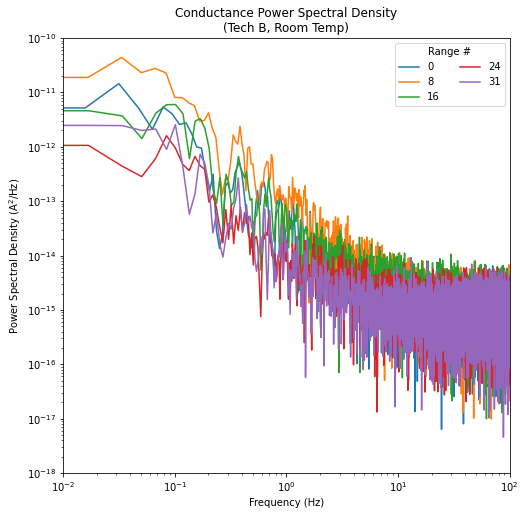

In [22]:
# Plot power spectral density (PSD)
import scipy.signal as signal
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title("Conductance Power Spectral Density\n(Tech B, Room Temp)")
for addr in list(range(0, 64, 16)) + [62]:
    adata = data[((data["addr"] % 64) == addr) & (data["time"] < 10)]
    f, p = signal.welch(0.2*adata["g"], fs=1/np.mean(np.diff(adata[:999]["time"])), average='median', nperseg=16000)
    # Hann window with length of 4096 per segment
    #plt.psd(adata[:99999]["g"], Fs=1/np.mean(np.diff(adata[:99999]["time"])))
    plt.plot(f, p, label=addr//2)
ax.legend(title="Range #", ncol=2)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density (A$^2$/Hz)")
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim(1e-16, 1e-8)
ax.set_xlim(0.01, 100)
ax.set_ylim(1e-18, 1e-10)

Let's look at the 5 levels we were considering before.

#### Example 1:

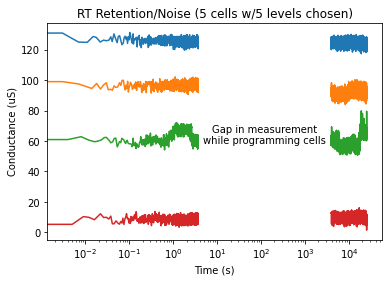

In [23]:
# Plot measured conductance vs. time
plt.title("RT Retention/Noise (5 cells w/5 levels chosen)")
plt.xlabel("Time (s)")
plt.ylabel("Conductance (uS)")
for addr in np.array(levels)*2:
    adata = data[data["addr"] == addr]
    plt.plot(adata["time"], adata["g"]*1e6)
plt.xscale("log")
rect = Rectangle((3.8, 0), 3600, 128, edgecolor=None, facecolor="white", zorder=10)
plt.gca().add_patch(rect)
plt.text(116.96, 64, "Gap in measurement\nwhile programming cells", zorder=20, ha="center", va="center")
plt.show()

#### Example 2:

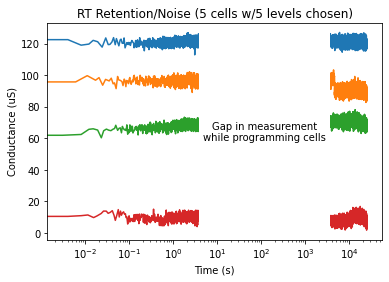

In [24]:
# Plot measured conductance vs. time
plt.title("RT Retention/Noise (5 cells w/5 levels chosen)")
plt.xlabel("Time (s)")
plt.ylabel("Conductance (uS)")
for addr in np.array(levels)*2 + 128:
    adata = data[data["addr"] == addr]
    plt.plot(adata["time"], adata["g"]*1e6)
plt.xscale("log")
rect = Rectangle((3.8, 0), 3600, 128, edgecolor=None, facecolor="white", zorder=10)
plt.gca().add_patch(rect)
plt.text(116.96, 64, "Gap in measurement\nwhile programming cells", zorder=20, ha="center", va="center")
plt.show()

#### Example 3:

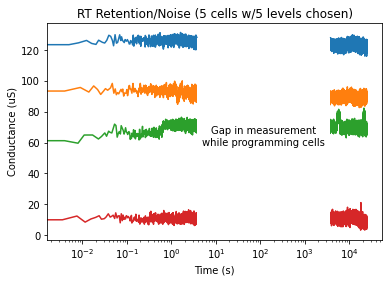

In [25]:
# Plot measured conductance vs. time
plt.title("RT Retention/Noise (5 cells w/5 levels chosen)")
plt.xlabel("Time (s)")
plt.ylabel("Conductance (uS)")
for addr in np.array(levels)*2 + 256:
    adata = data[data["addr"] == addr]
    plt.plot(adata["time"], adata["g"]*1e6)
plt.xscale("log")
rect = Rectangle((3.8, 0), 3600, 128, edgecolor=None, facecolor="white", zorder=10)
plt.gca().add_patch(rect)
plt.text(116.96, 64, "Gap in measurement\nwhile programming cells", zorder=20, ha="center", va="center")
plt.show()

The conclusion is that READ noise and drift may become an issue when you place levels too close together. If we remove the second (orange) level, we have 2 bits per cell and the READ noise does not appear to pose an issue after 7 hours. 

### Room-Temperature READ Distribution after ~7hrs

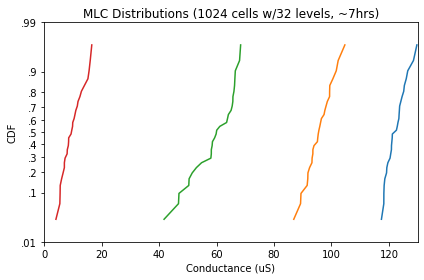

In [26]:
# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (1024 cells w/32 levels, ~7hrs)")
tdata = data.groupby("addr").nth(-1)
for i in levels:
    rdata = tdata[tdata["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 130)
plt.ylim(0.01, 0.99)
plt.tight_layout()
plt.show()

### Conductance Deviation vs. Initial Conductance

A good way to understand the stability of each conductance level is to look at the *conductance deviation plot* shown below. Intermediate conductances are less stable.

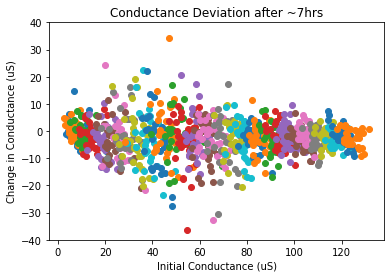

In [27]:
# Get first and last conductance values
firstdata = data.groupby("addr").nth(0)
lastdata = data.groupby("addr").nth(-1)
plt.title("Conductance Deviation after ~7hrs")
plt.xlabel("Initial Conductance (uS)")
plt.ylabel("Change in Conductance (uS)")
for i in range(32):
    fdata = firstdata[firstdata["targbin"] == i]["g"]*1e6
    ldata = lastdata[lastdata["targbin"] == i]["dg"]*1e6
    plt.plot(fdata, ldata, 'o')
    plt.ylim(-40, 40)
plt.show()

### Average Absolute Conductance Deviation vs. Time

Average conductance deviation vs. time seems to increase in a power-law fashion. There seems to be a difference in the exponent based on the conductance level. Intermediate conductances deviate the fastest.


Level 1: a = 2.4637135026401653, k = 0.01228137043907722, CoV(a) = [ 6.56920050e-04 -2.38542357e-05], CoV(k) = [-2.38542357e-05  2.21645516e-06]
Level 8: a = 5.643561560592739, k = 0.03872964695604017, CoV(a) = [ 0.0095294 -0.0001672], CoV(k) = [-1.67200293e-04  5.08458049e-06]
Level 16: a = 3.285581684297174, k = 0.03796997700186154, CoV(a) = [ 1.29802993e-03 -3.90410774e-05], CoV(k) = [-3.90410774e-05  2.05266689e-06]
Level 24: a = 2.6242165725826765, k = 0.03886244785757251, CoV(a) = [ 9.03579387e-04 -3.41070952e-05], CoV(k) = [-3.41070952e-05  2.22804311e-06]
Level 31: a = 2.2353000732528523, k = 0.01131299905520381, CoV(a) = [ 5.45099060e-04 -2.17011067e-05], CoV(k) = [-2.17011067e-05  2.25219288e-06]
No handles with labels found to put in legend.


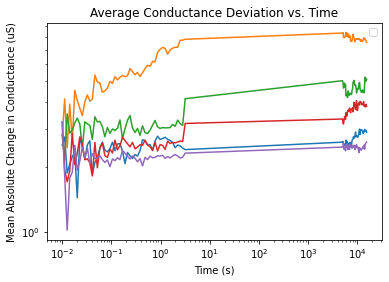

In [28]:
# Plot setup
plt.title("Average Conductance Deviation vs. Time")
plt.xlabel("Time (s)")
plt.ylabel("Mean Absolute Change in Conductance (uS)")

# Define time intervals to group together
time_intervals = np.concatenate([np.logspace(-2, 0.5, 50), np.logspace(3.7, 4.2, 50)])

# Define fit function
fit_fn = lambda x, a, k: a*x**k

# For each level
levels = [1, 8, 16, 24, 31]
for i in levels:
    ldata = data[data["targbin"] == i]
    mean_abs_dg = ldata.groupby(pd.cut(ldata["time"], time_intervals))["absdg"].mean() * 1e6
    xdata = [c.left for c in mean_abs_dg.index.values]
    ydata = mean_abs_dg.values
    popt, pcov = scipy.optimize.curve_fit(fit_fn, xdata, ydata)
    print(f"Level {i}: a = {popt[0]}, k = {popt[1]}, CoV(a) = {pcov[0]}, CoV(k) = {pcov[1]}")
    p = plt.plot([c.left for c in mean_abs_dg.index.values], mean_abs_dg, "-")
    fitx = np.logspace(-2, 4.2)
    fity = fit_fn(fitx, *popt)
    #plt.plot(fitx, fity, color=p[-1].get_color(), label=i)
plt.legend()
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.show()

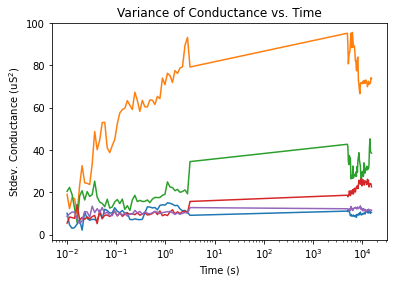

In [29]:
# Plot setup
plt.title("Variance of Conductance vs. Time")
plt.xlabel("Time (s)")
plt.ylabel("Variance Conductance (uS$^2$)")

# Define time intervals to group together
time_intervals = np.concatenate([np.logspace(-2, 0.5, 50), np.logspace(3.7, 4.2, 50)])

# Define fit function
fit_fn = lambda x, a, k: np.sqrt(a*np.log(x)+k)

# For each level
for i in levels:
    ldata = data[data["targbin"] == i]
    mean_abs_dg = ldata.groupby(pd.cut(ldata["time"], time_intervals))["g"].var() * (1e6)**2
    #xdata = [c.left for c in mean_abs_dg.index.values]
    #ydata = mean_abs_dg.values
    #popt, pcov = scipy.optimize.curve_fit(fit_fn, xdata, ydata, p0=[])
    #print(f"Level {i}: a = {popt[0]}, k = {popt[1]}, CoV(a) = {pcov[0]}, CoV(k) = {pcov[1]}")
    p = plt.plot([c.left for c in mean_abs_dg.index.values], mean_abs_dg, "-")
    # fitx = np.logspace(-2, 4.2)
    # fity = fit_fn(fitx, *popt)
    # plt.plot(fitx, fity, color=p[-1].get_color())
plt.gca().set_xscale("log")
plt.show()

### High-Temperature Retention

To perform high-temperature retention measurements, the chips were programmed and measured, then placed on a hot plate for 1 hour. After 1 hour, the chip was remeasured. The results are presented at three temperatures below.

One interesting observation is that the pre-bake distributions keep getting worse and worse. This means that the post-programmed relaxation is somehow affected by the baking. **TODO: do retention/relaxation/noise measurements after baking**

#### 85C for 1hr

At 85C, there appears to be little effect of the baking on the resistance distributions.

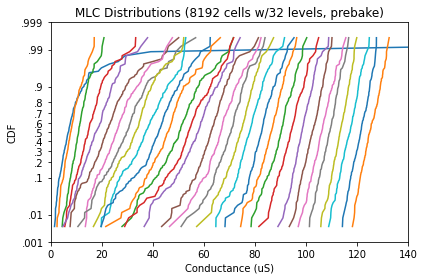

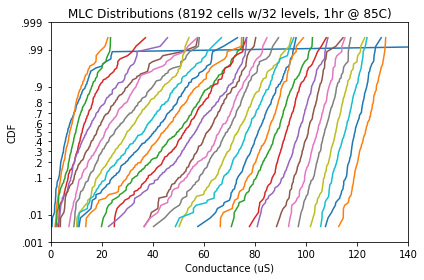

In [28]:
# Load data
names = ["addr", "r"]
data = pd.read_csv("../data/prebake85.tsv", sep="\t", names=names)
data = data[(data["addr"] // 2048) % 4 != 1]
data = data[(data["addr"] // 2048) % 4 != 2]
data["g"] = 1/data["r"]
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32

# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (8192 cells w/32 levels, prebake)")
for i in range(32):
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 140)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

# Load data
names = ["addr", "r"]
data = pd.read_csv("../data/postbake85.tsv", sep="\t", names=names)
data = data[(data["addr"] // 2048) % 4 != 1]
data = data[(data["addr"] // 2048) % 4 != 2]
data["g"] = 1/data["r"]
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32

# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (8192 cells w/32 levels, 1hr @ 85C)")
for i in range(32):
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 140)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

#### 110C for 1hr

At 110C, there appears to be little effect of the baking on the resistance distributions.

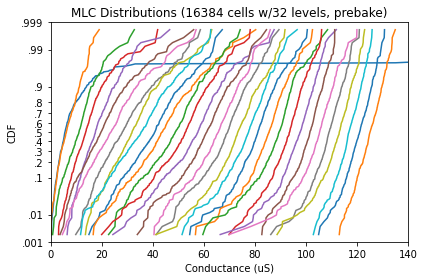

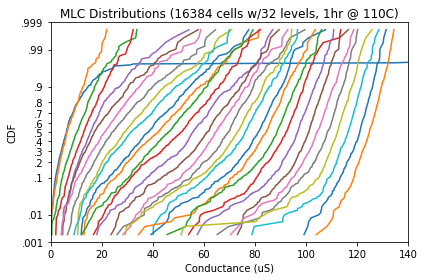

In [29]:
# Load data
names = ["addr", "r"]
data = pd.read_csv("../data/prebake110.tsv", sep="\t", names=names)
data["g"] = 1/data["r"]
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32

# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (16384 cells w/32 levels, prebake)")
for i in range(32):
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 140)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

# Load data
names = ["addr", "r"]
data = pd.read_csv("../data/postbake110.tsv", sep="\t", names=names)
data["g"] = 1/data["r"]
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32

# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (16384 cells w/32 levels, 1hr @ 110C)")
for i in range(32):
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 140)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

#### 130C for 1hr

At 130C, there appears to be little new effect of the baking on the resistance distributions.

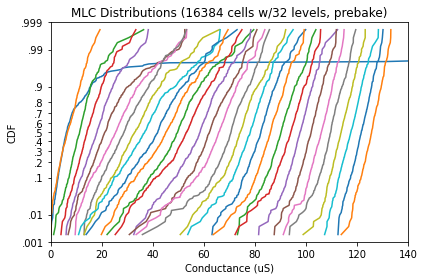

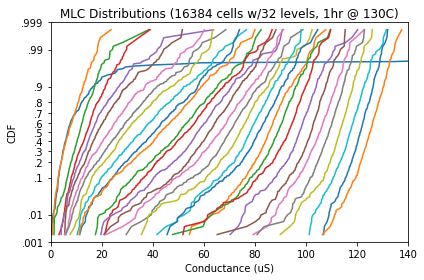

In [30]:
# Load data
names = ["addr", "r"]
data = pd.read_csv("../data/prebake130.tsv", sep="\t", names=names)
data["g"] = 1/data["r"]
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32

# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (16384 cells w/32 levels, prebake)")
for i in range(32):
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 140)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

# Load data
names = ["addr", "r"]
data = pd.read_csv("../data/postbake130.tsv", sep="\t", names=names)
data["g"] = 1/data["r"]
data["targbin"] = ((data["addr"] - data["addr"][0]) / 2) % 32

# Show distribution
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (16384 cells w/32 levels, 1hr @ 130C)")
for i in range(32):
    rdata = data[data["targbin"] == i]
    plt.plot(sorted(rdata["g"].values * 1e6), np.linspace(0, 1, len(rdata)))
plt.xlabel("Conductance (uS)")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 140)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()

#### Average deviation from programmed value vs. temperature after 1hr

This indicates that there is little impact of baking on the chip. Possibly, electrical pulses are required during the heating for there to be an effect. Or the hot plate baking method may not be the right approach.

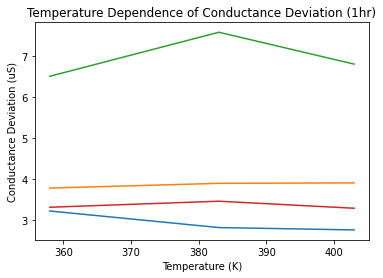

In [31]:
names = ["addr", "r"]
temps = [85, 110, 130]

absdg_levels = []
for temp in temps:
    # Load prebake data
    predata = pd.read_csv(f"../data/prebake{temp}.tsv", sep="\t", names=names)
    predata["g"] = 1e6/predata["r"]
    predata = predata[(predata["addr"] // 2048) % 4 != 1]
    predata = predata[(predata["addr"] // 2048) % 4 != 2]
    predata["targbin"] = ((predata["addr"] - predata["addr"][0]) / 2) % 32

    # Load postbake data
    postdata = pd.read_csv(f"../data/postbake{temp}.tsv", sep="\t", names=names)
    postdata["g"] = 1e6/postdata["r"]
    postdata = postdata[(postdata["addr"] // 2048) % 4 != 1]
    postdata = postdata[(postdata["addr"] // 2048) % 4 != 2]
    postdata["targbin"] = ((postdata["addr"] - postdata["addr"][0]) / 2) % 32
    postdata["dg"] = postdata["g"] - predata["g"]
    postdata["absdg"] = np.abs(postdata["dg"])

    absdg_levels.append([postdata[postdata["targbin"] == i]["absdg"].values.mean() for i in levels])

plt.title("Temperature Dependence of Conductance Deviation (1hr)")
plt.xlabel("Temperature (K)")
plt.ylabel("Conductance Deviation (uS)")
for d, level in zip(np.array(absdg_levels).T, levels):
    plt.plot(np.array(temps) + 273, d, label=str(level))


## Endurance

To measure endurance, we perform SET/RESET cycling using a hardware-timed pulse train without READing (fast mode). The pulse train waveform is verified with the oscilloscope. We also validate with a software-timed pulse train (slow mode), which generally exhibits good agreement with the hardware-timed pulse train. We test different SET conditions at 1us and 20ns. We are basically unable to get the cells to fail in a reasonable amount of testing time.

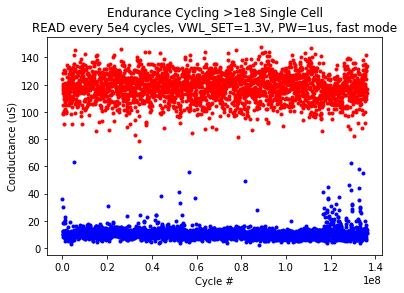

In [32]:
# Show cycling up to 1e8
data = pd.read_csv("../data/endurance_log.csv", header=None)
data = data[data[3] == "READ"]
data["g"] = 1e6/np.float64(data[4])
plt.title("Endurance Cycling >1e8 Single Cell\nREAD every 5e4 cycles, VWL_SET=1.3V, PW=1us, fast mode")
plt.xlabel("Cycle #")
plt.ylabel("Conductance (uS)")
plt.plot(np.arange(len(data["g"][::2]))*5e4, data["g"][::2], "b.")
plt.plot(np.arange(len(data["g"][1::2]))*5e4, data["g"][1::2], "r.")
plt.show()

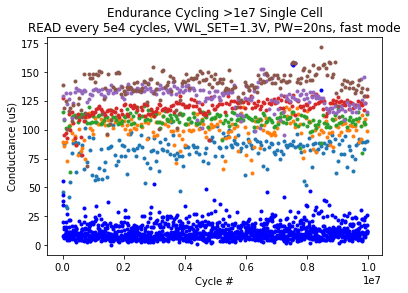

In [33]:
# Show cycling up to 1e7 for different VWLs
data = pd.read_csv("../data/endurance_log_many.csv", header=None)
data = data[data[3] == "READ"]
data["g"] = 1e6/np.float64(data[4])
plt.title("Endurance Cycling >1e7 Single Cell\nREAD every 5e4 cycles, VWL_SET=1.3V, PW=20ns, fast mode")
plt.xlabel("Cycle #")
plt.ylabel("Conductance (uS)")
for addr in [768, 770, 772, 774, 776, 778]:
    adata = data[data[2] == addr]
    plt.plot(np.arange(len(adata["g"][::2]))*5e4, adata["g"][::2], "b.")
    plt.plot(np.arange(len(adata["g"][1::2]))*5e4, adata["g"][1::2], ".")
plt.show()

## Sweeps

**TODO**

## Programming Methods and Tuning

Here, we evaluate various write-verify programming methods. In particular, we test out FPPV, ISPP, DD-ISPP,Smart-ISPP, Smart-DD-ISPP, GSR, and RADAR. Each algorithm uses fixed pulse width and assumes block RESET operation is available (GSR and (Smart)-DD-ISPP methods do not need block RESET). The algorithms are described below and each has tradeoffs in terms of:

1. *Number of tunable parameters:* fewer means that the parameter tuning process is more straightforward and less time-consuming to configure, but greater number of parameters typically leads to lower pulse count
2. *Dynamic range of WL/BL/SL voltages:* having fewer voltage levels to apply simplifies peripheral design in the array
3. *Number of pulses required:* having fewer is always better, but usually requires more parameters to tune
4. *Difficulty of implementation:* simpler algorithms require less control logic

|               | Tunable Parameters per Level | Difficulty of Implementation | Dynamic Range Required | Pulse Count (Estimate) |
|---------------|------------------------------|------------------------------|------------------------|------------------------|
| FPPV          | 1                            | 1                            | 1                      | 5                      |
| ISPP          | 1                            | 1                            | 2                      | 5                      |
| DD-ISPP       | 2                            | 2                            | 2                      | 4                      |
| Smart-ISPP    | 2                            | 2                            | 2                      | 3                      |
| Smart-DD-ISPP | 3                            | 3                            | 2                      | 2                      |
| RADAR         | 5                            | 4                            | 3                      | 1                      |
| GSR           | 8                            | 3                            | 3                      | 2                      |

The tradeoffs for each algorithm will be described further below in the corresponding section.

**TODO**

### FPPV

FPPV stands for Fixed Pulse Programming Voltage method, and as its name suggests, it involves the use of fixed amplitude pulses to program a cell to a given range. In terms of dynamic range: there is one BL level (for SET) and one SL level (for RESET). For WL voltage, there is one level for each targeted programming range. Hence, for targeting of `N` programming ranges, only `N` DAC levels are necessary for the WL, which is advantageous in terms of area (and potentially power) when designing peripheral memory circuits.

The idea of the algorithm is that when targeting a range `i`, you apply a pulse with the WL voltage that gets you there the fastest. As long as your conductance is lower than the target, you keep applying SET pulses with the corresponding amplitude, and when the conductance goes above the target, you use a strong RESET pulse to get back to HRS and try again.

FPPV is relatively easy to tune; first, you perform a sweep to determine how the WL voltage affects the final conductance, then you pick the WL voltages that result in the desired conductance range being achieved in minimum number of pulses.

**TODO**: make `fppv_tune.py`

### ISPP

ISPP stands for Incremental Step Pulse Programming method, and as its name suggests, it involves the use of increasing (WL voltage) amplitude pulses to program a cell to a given range. In terms of dynamic range: there is one BL level (for SET) and one SL level (for RESET). For WL voltage, there is typically a larger degree of tunability required, and hence a higher resolution DAC will need to be used than for FPPV.

The idea of the algorithm is that when targeting a range `i`, you start from `VWL = 0V` and keep stepping up the WL voltage until you get to the target. As long as your conductance is lower than the target, you keep applying SET pulses with the corresponding amplitude, and when the conductance goes above the target, you use a strong RESET pulse to get back to HRS and try again.

ISPP is very easy to tune; there is only one parameter, the step size. To tune it, you can thus simply evaluate the algorithm with different step sizes.

**TODO:** make `ispp_tune.py`